In [1]:
# Improt the necessary libraries
import itertools
import xarray as xr
import rasterio
import pandas as pd
import geopandas as gpd
import rioxarray
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as colormap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
# Filepaths

WTE_FOLDER = "/mnt/drive/AI4EBV/INPUTS/WTE/"
WTE_GLOBAL = "WTE1778_global.tif"

# Wte table

WTE_TABLE = WTE_FOLDER + "Tables/Realm_WE_attribute_Table_DraftSort.csv"

# Himalayas 4 tiles shapefile

HIMALAYA_SHP = "/mnt/drive/AI4EBV/BOUNDARIES/Himalayas_4_tiles.shp"

OUTPUT_CRS = "EPSG:32645"

Read the input WTE layer

In [3]:
wte_global = xr.open_rasterio(WTE_FOLDER + WTE_GLOBAL)
wte_global

<xarray.DataArray (band: 1, y: 62171, x: 160299)>
[9965949129 values with dtype=int16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 83.62 83.62 83.62 83.62 ... -55.99 -55.99 -56.0 -56.0
  * x        (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0 180.0
Attributes:
    transform:      (0.002245799, 0.0, -179.999999, 0.0, -0.002245799, 83.624...
    crs:            +init=epsg:4326
    res:            (0.002245799, 0.002245799)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('Band Math (fix(b1))',)
    AREA_OR_POINT:  Area
    Band_1:         Band Math (fix(b1))

Read the input shapefile

In [4]:
df = gpd.read_file(HIMALAYA_SHP)
df[df.index==0].geometry

0    POLYGON Z ((84.94795 28.91264 0.00000, 86.0739...
Name: geometry, dtype: geometry

In [5]:
df_merged = df.dissolve().explode()
df_merged.geometry.bounds

,,minx,miny,maxx,maxy
0,0,84.947953,27.019727,87.100136,28.928245


In [6]:
minX = df_merged.geometry.bounds['minx']
minY = df_merged.geometry.bounds['miny']
maxX = df_merged.geometry.bounds['maxx']
maxY = df_merged.geometry.bounds['maxy']

In [7]:
wte_table = pd.read_csv(WTE_TABLE, sep=';')
wte_table

,RealmWE_ID,WE_ID,Realm_ID,RealmClass,LF_Class,MoistClass,TempClass,LC_Class,Realm_Name,LF_Name,LC_Name,Temp_Name,Moist_Name,Temp_Moist,WEcosystm,RWEcosystm,LandC_Type,Code
0,1005,5,1000,1,1,3,6,6,Afrotropic,Mountains,Sparsley or Non vegetated,Polar,Moist,Polar Moist,Polar Moist Sparsley or Non vegetated on Mount...,Afrotropic Polar Moist Sparsley or Non vegetat...,Natural,6316
1,1010,10,1000,1,3,3,6,6,Afrotropic,Tablelands,Sparsley or Non vegetated,Polar,Moist,Polar Moist,Polar Moist Sparsley or Non vegetated on Table...,Afrotropic Polar Moist Sparsley or Non vegetat...,Natural,6336
2,1016,16,1000,1,2,3,6,6,Afrotropic,Hills,Sparsley or Non vegetated,Polar,Moist,Polar Moist,Polar Moist Sparsley or Non vegetated on Hills,Afrotropic Polar Moist Sparsley or Non vegetat...,Natural,6326
3,1018,18,1000,1,1,3,6,4,Afrotropic,Mountains,Grassland,Polar,Moist,Polar Moist,Polar Moist Grassland on Mountains,Afrotropic Polar Moist Grassland on Mountains,Natural,6314
4,1024,24,1000,1,3,3,6,2,Afrotropic,Tablelands,Shrubland,Polar,Moist,Polar Moist,Polar Moist Shrubland on Tablelands,Afrotropic Polar Moist Shrubland on Tablelands,Natural,6332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,8399,399,8000,8,1,3,3,8,Palearctic,Mountains,Snow and Ice,Warm Temperate,Moist,Warm Temperate Moist,Warm Temperate Moist Snow and Ice on Mountains,Palearctic Warm Temperate Moist Snow and Ice o...,Natural,3318
1777,8400,400,8000,8,3,1,4,3,Palearctic,Tablelands,Forest,Sub Tropical,Desert,Sub Tropical Desert,Sub Tropical Desert Forest on Tablelands,Palearctic Sub Tropical Desert Forest on Table...,Natural,4133
1778,8406,406,8000,8,2,1,5,3,Palearctic,Hills,Forest,Tropical,Desert,Tropical Desert,Tropical Desert Forest on Hills,Palearctic Tropical Desert Forest on Hills,Natural,5123
1779,8412,412,8000,8,3,1,5,2,Palearctic,Tablelands,Shrubland,Tropical,Desert,Tropical Desert,Tropical Desert Shrubland on Tablelands,Palearctic Tropical Desert Shrubland on Tablel...,Natural,5132


# Moisture regime

In [8]:
WTE_MOISTURE_RULESET = "./moisture_ruleset.csv"
moisture_ruleset = pd.read_csv(WTE_MOISTURE_RULESET, sep=';')
moisture_ruleset

,WTE_moisture_domains,aridity_index,WTE_moisture_domain_code
0,Moist,>0.65,3
1,Dry,0.05:0.65,2
2,Desert,<0.05,1


## WTE Moisture Layer

In [10]:
wte_clipped = wte_global.rio.clip_box(minx=minX,miny=minY,maxx=maxX,maxy=maxY)
max_value = wte_clipped.max().values
while(max_value>3):
    moistValue = wte_table.loc[wte_table['RealmWE_ID']==max_value]['MoistClass']
    if len(moistValue) != 0:
        wte_clipped = wte_clipped.where(wte_clipped!=max_value).fillna(int(moistValue))
    else:
        break
    max_value = wte_clipped.max().values
wte_clipped = wte_clipped.where(wte_clipped!=wte_clipped.attrs["_FillValue"])
wte_clipped = wte_clipped.where(wte_clipped!=7)
wte_clipped.attrs["_FillValue"] = np.nan

Define colors and labels for plotting:

In [11]:
moisture_cmap = {'Desert':"#F5F57A",'Dry':"#E68900",'Moist':"#728944"}
legend = []
for i,x in enumerate(moisture_ruleset['WTE_moisture_domain_code']):
    label = moisture_ruleset.loc[moisture_ruleset['WTE_moisture_domain_code']==x]['WTE_moisture_domains'].values[0]
    color = moisture_cmap[label]
    legend.append(mpatches.Patch(color=color,label=label))

colors_diff = ["#00375D","#0000CC","#00CCCC","#E0E0E0","#FFAA00","#CC0000","#660000"]
labels_diff = ["-3 zones","-2 zones","-1 zone","same zone","+1 zone","+2 zones","+3 zones"]
legend_diff = []
for i,x in enumerate(labels_diff):
    legend_diff.append(mpatches.Patch(color=colors_diff[i],label=x))

Create cmap for temperature layer

In [12]:
cmap_moist = ListedColormap(["#F5F57A","#E68900","#728944"])

Create cmap for difference layer

In [13]:
diff_cmap = ListedColormap(["#00375D","#0000CC","#00CCCC","#E0E0E0","#FFAA00","#CC0000","#660000"])

Reproject to the desired UTM projection:

In [14]:
wte_moist_UTM = wte_clipped.rio.reproject(OUTPUT_CRS,resolution=250, resampling=6)
# wte_moist_UTM = wte_clipped.rio.reproject(wte_clipped.rio.estimate_utm_crs(),resolution=250, resampling=0) # New Proj required

[]

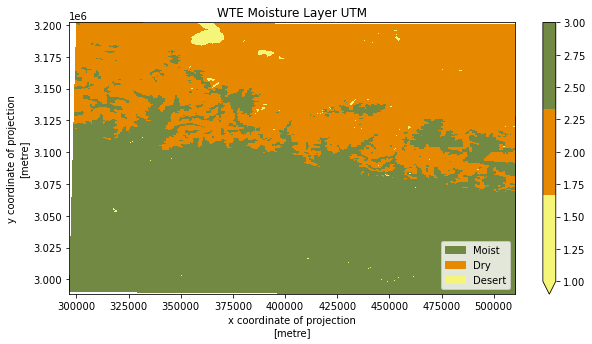

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
fig = wte_moist_UTM[0].plot.imshow(ax=ax,cmap=cmap_moist,vmax=3, vmin=1)
ax.set_title("WTE Moisture Layer UTM")
ax.legend(handles=legend,loc='lower right')
ax.margins(10)
plt.plot()

In [16]:
# wte_moist_UTM[0].to_netcdf("wte_moist_UTM_Himalaya.nc")

## CGIAR

In [17]:
CGIAR_ARIDITY_INDEX = "/mnt/drive/AI4EBV/INPUTS/CLIMATE/CGIAR/v2/ai_et0/ai_et0.tif"

Aridity Index

In [18]:
cgiar_aridity_ind = xr.open_rasterio(CGIAR_ARIDITY_INDEX,chunks=1000)
print(cgiar_aridity_ind)

<xarray.DataArray (band: 1, y: 18000, x: 43200)>
dask.array<open_rasterio-2f4b2e5eb0134ac6a48322056a533cb7<this-array>, shape=(1, 18000, 43200), dtype=int32, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 90.0 89.99 89.98 89.97 ... -59.97 -59.98 -59.99 -60.0
  * x        (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0 180.0
Attributes:
    transform:      (0.00833333333333333, 0.0, -180.0, 0.0, -0.00833333333333...
    crs:            +init=epsg:4326
    res:            (0.00833333333333333, 0.00833333333333333)
    is_tiled:       1
    nodatavals:     (-2147483647.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    DataType:       Generic


Clip the data to our region of interest

In [19]:
cgiar_aridity_ind_clipped = cgiar_aridity_ind.rio.clip_box(minx=minX,miny=minY,maxx=maxX,maxy=maxY)
cgiar_aridity_ind_clipped = cgiar_aridity_ind_clipped.where(cgiar_aridity_ind_clipped!=cgiar_aridity_ind_clipped.attrs["_FillValue"])
cgiar_aridity_ind_clipped.attrs["_FillValue"] = np.nan
cgiar_aridity_ind_clipped = (cgiar_aridity_ind_clipped/10000).compute()

Reprojection to 250m in UTM with cubic interpolation

In [20]:
cgiar_aridity_ind_clipped = cgiar_aridity_ind_clipped.rio.reproject_match(wte_moist_UTM,2)
cgiar_aridity_ind_clipped = cgiar_aridity_ind_clipped.where(cgiar_aridity_ind_clipped!=cgiar_aridity_ind_clipped.attrs["_FillValue"])
cgiar_aridity_ind_clipped.attrs["_FillValue"] = np.nan

[]

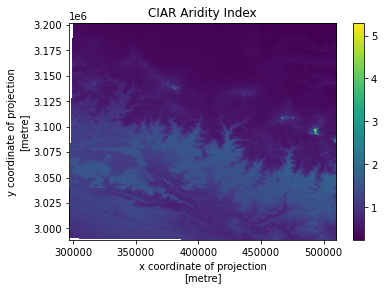

In [21]:
fig, ax = plt.subplots()
(cgiar_aridity_ind_clipped[0]).plot.imshow(ax=ax)
ax.set_title("CIAR Aridity Index")
plt.plot()

Classification of CGIAR according to the WTE scheme

In [22]:
# Create a NaN mask
na_mask = np.bitwise_not(xr.ufuncs.isnan(cgiar_aridity_ind_clipped))
# Create the output layer
cgiar_to_wte = xr.zeros_like(cgiar_aridity_ind_clipped)

In [23]:
# Moist (Humid): WTE domain code = 3
cgiar_to_wte = cgiar_to_wte + (cgiar_aridity_ind_clipped>0.65)*3
# Dry (Arid):  WTE domain code = 2
cgiar_to_wte = cgiar_to_wte + (np.bitwise_and(cgiar_aridity_ind_clipped>=0.05,cgiar_aridity_ind_clipped<=0.65))*2
# Desert (Hyperarid): WTE domain code = 1
cgiar_to_wte = cgiar_to_wte + (cgiar_aridity_ind_clipped<0.05)*1
# Apply NaNs mask
cgiar_to_wte = cgiar_to_wte.where(na_mask)

[]

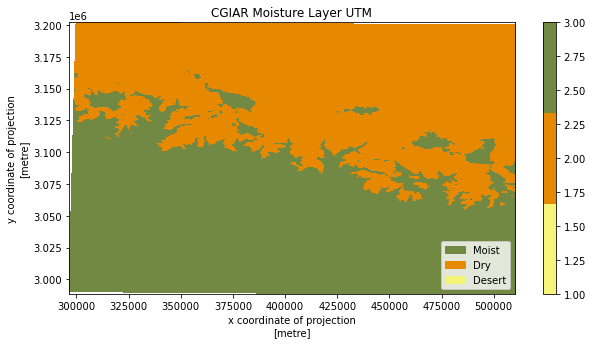

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
fig = cgiar_to_wte[0].plot.imshow(ax=ax,cmap=cmap_moist,vmax=3, vmin=1)
ax.set_title("CGIAR Moisture Layer UTM")
ax.legend(handles=legend,loc='lower right')
ax.margins(10)
plt.plot()

In [25]:
# cgiar_to_wte[0].to_netcdf("cgiar_to_wte_moist_UTM_Himalaya.nc")

Combine the NaN masks and mask the data to avoid not overlapping pixels due to reprojection:

In [26]:
na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(wte_moist_UTM),xr.ufuncs.isnan(cgiar_to_wte)))
wte_moist_UTM_masked_cgiar = wte_moist_UTM.where(na_mask)
cgiar_to_wte_UTM_masked = cgiar_to_wte.where(na_mask)

Now that we have both moisture layers with the same class scheme and projection we can compute the difference:

In [27]:
wte_cgiar_diff = wte_moist_UTM_masked_cgiar - cgiar_to_wte_UTM_masked

[]

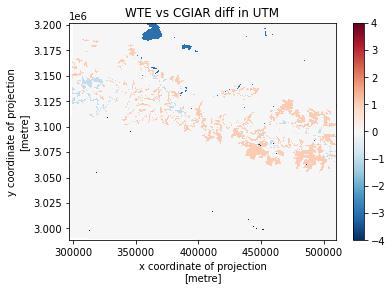

In [28]:
fig, ax = plt.subplots()
wte_cgiar_diff[0].plot.imshow(ax=ax)
ax.set_title("WTE vs CGIAR diff in UTM")
plt.plot()

## Chelsa 1.2

In [29]:
CHELSA_ROOT = "/mnt/drive/AI4EBV/INPUTS/CLIMATE/CHELSA/"
CHELSA_ANNUAL_PRECIPITATION = CHELSA_ROOT + "CHELSA_bio10_12.tif"
CHELSA_POT_EVAPOTRANSPIRATION = CHELSA_ROOT + "CHELSA_pet_annual_mean_1979-2013.tif"

The UNEP has adopted yet another index of aridity, defined as:

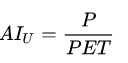

where PET is the potential evapotranspiration and P is the average annual precipitation (UNEP, 1992).

Aridity Index

In [30]:
chelsa_annual_prec = xr.open_rasterio(CHELSA_ANNUAL_PRECIPITATION,chunks=1000).rio.clip_box(minx=minX,miny=minY,maxx=maxX,maxy=maxY)
chelsa_annual_prec = chelsa_annual_prec.where(chelsa_annual_prec!=chelsa_annual_prec.attrs["_FillValue"])
chelsa_annual_prec.attrs["_FillValue"] = np.nan
chelsa_pot_evap    = xr.open_rasterio(CHELSA_POT_EVAPOTRANSPIRATION,chunks=1000).rio.clip_box(minx=minX,miny=minY,maxx=maxX,maxy=maxY)
chelsa_pot_evap = chelsa_pot_evap.where(chelsa_pot_evap!=chelsa_pot_evap.attrs["_FillValue"])
chelsa_pot_evap.attrs["_FillValue"] = np.nan

/home/euracuser/miniconda3/envs/pysegcnn/lib/python3.7/site-packages/rioxarray/raster_writer.py:109: UserWarning: The nodata value (-3.4e+38) has been automatically changed to (-3.3999999521443642e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "


The data has sligtly differences in the coordinates due to rounding errors. Before being able to combine the data we need to align them:

In [31]:
chelsa_annual_prec['x'] = chelsa_annual_prec.x.astype(np.float32)
chelsa_annual_prec['y'] = chelsa_annual_prec.y.astype(np.float32)
chelsa_pot_evap['x'] = chelsa_pot_evap.x.astype(np.float32)
chelsa_pot_evap['y'] = chelsa_pot_evap.y.astype(np.float32)

In [32]:
chelsa_aridity_ind = (chelsa_annual_prec / chelsa_pot_evap).compute()

Reprojection to 250m in UTM with cubic interpolation

In [33]:
chelsa_aridity_ind = chelsa_aridity_ind.rio.reproject_match(wte_moist_UTM,2)
chelsa_aridity_ind = chelsa_aridity_ind.where(chelsa_aridity_ind!=chelsa_aridity_ind.attrs["_FillValue"])
chelsa_aridity_ind.attrs["_FillValue"] = np.nan

[]

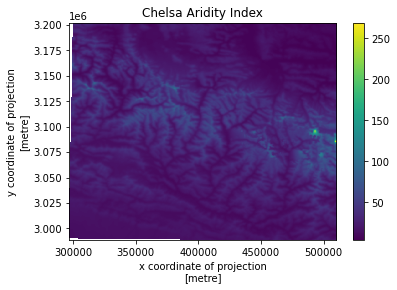

In [34]:
fig, ax = plt.subplots()
chelsa_aridity_ind[0].plot.imshow(ax=ax)
ax.set_title("Chelsa Aridity Index")
plt.plot()

Classification of Chelsa according to the WTE scheme

In [35]:
# Create a NaN mask
na_mask = np.bitwise_not(xr.ufuncs.isnan(chelsa_aridity_ind))
# Create the output layer
chelsa_to_wte = xr.zeros_like(chelsa_aridity_ind)

In [36]:
# Moist (Humid): WTE domain code = 3
chelsa_to_wte = chelsa_to_wte + (chelsa_aridity_ind>0.65)*3
# Dry (Arid):  WTE domain code = 2
chelsa_to_wte = chelsa_to_wte + (np.bitwise_and(chelsa_aridity_ind>=0.05,chelsa_aridity_ind<=0.65))*2
# Desert (Hyperarid): WTE domain code = 1
chelsa_to_wte = chelsa_to_wte + (chelsa_aridity_ind<0.05)*1
# Apply NaNs mask
chelsa_to_wte = chelsa_to_wte.where(na_mask)

[]

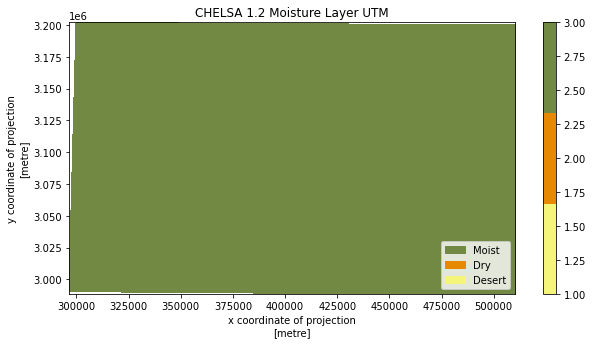

In [37]:
fig, ax = plt.subplots(figsize=(10,5))
fig = chelsa_to_wte[0].plot.imshow(ax=ax,cmap=cmap_moist,vmax=3, vmin=1)
ax.set_title("CHELSA 1.2 Moisture Layer UTM")
ax.legend(handles=legend,loc='lower right')
ax.margins(10)
plt.plot()

In [38]:
# chelsa_to_wte[0].to_netcdf("chelsa_to_wte_moist_UTM_Himalaya.nc")

Combine the NaN masks and mask the data to avoid not overlapping pixels due to reprojection:

In [39]:
na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(wte_moist_UTM),xr.ufuncs.isnan(chelsa_to_wte)))
wte_moist_UTM_masked_chelsa = wte_moist_UTM.where(na_mask)
chelsa_to_wte_UTM_masked = chelsa_to_wte.where(na_mask)

Now that we have both temperature layers with the same class scheme and projection we can compute the difference:

In [40]:
wte_chelsa_diff = wte_moist_UTM_masked_chelsa - chelsa_to_wte_UTM_masked

[]

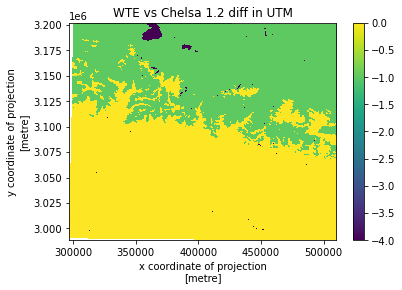

In [41]:
fig, ax = plt.subplots()
wte_chelsa_diff[0].plot.imshow(ax=ax)
ax.set_title("WTE vs Chelsa 1.2 diff in UTM")
plt.plot()

Table resuming the correspondence between the data
1. Compute the number of pixels which are non zero
2. Compute the percentage and the area in km^2 of the difference

In [42]:
#WTE vs CGIAR:
wte_cgiar_diff_km2 = np.count_nonzero(wte_cgiar_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
wte_cgiar_diff_dis = np.count_nonzero(wte_cgiar_diff.fillna(0))/np.count_nonzero(~np.isnan(wte_cgiar_diff))*100 #Percentage of disagreement
#WTE vs CHELSA:
wte_chelsa_diff_km2 = np.count_nonzero(wte_chelsa_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
wte_chelsa_diff_dis = np.count_nonzero(wte_chelsa_diff.fillna(0))/np.count_nonzero(~np.isnan(wte_chelsa_diff))*100 #Percentage of disagreement

In [43]:
import pandas as pd

data = {'Disagreement [km^2]':  [wte_cgiar_diff_km2, wte_chelsa_diff_km2],
        'Disagreement [%]': [wte_cgiar_diff_dis, wte_chelsa_diff_dis],
        }

df = pd.DataFrame(data, columns = ['Disagreement [km^2]','Disagreement [%]'],
                        index=['WTE vs CGIAR','WTE vs Chelsa 2.1'])

df

,Disagreement [km^2],Disagreement [%]
WTE vs CGIAR,3055.125,6.78978
WTE vs Chelsa 2.1,19004.250,42.23548


In [44]:
def plot_confusion_matrix(ax, cm, labels, normalize=True, cmap='Blues',true="WTE",predicted="predicted"):
    """Plot the confusion matrix ``cm``.
    Parameters
    ----------
    cm : :py:class:`numpy.ndarray`
        The confusion matrix.
    labels : `list` [`str`]
        Names of the classes.
    normalize : `bool`, optional
        Whether to normalize the confusion matrix. The default is `True`.
    figsize : `tuple` [`int`], optional
        The figure size in centimeters. The default is `(10, 10)`.
    cmap : `str`, optional
        A matplotlib colormap. The default is `'Blues'`.
    Returns
    -------
    fig : :py:class:`matplotlib.figure.Figure`
        An instance of :py:class:`matplotlib.figure.Figure`.
    ax : :py:class:`matplotlib.axes._subplots.AxesSubplot`
        An instance of :py:class:`matplotlib.axes._subplots.AxesSubplot`.
    """
    # number of classes
    nclasses = len(labels)

    # string format to plot values of confusion matrix
    fmt = '.0f'

    # minimum and maximum values of the colorbar
    vmin, vmax = 0, cm.max()

    # check whether to normalize the confusion matrix
    if normalize:
        # normalize
        norm = cm.sum(axis=1, keepdims=True)

        # check for division by zero
        norm[norm == 0] = 1
        cm = cm / norm

        # change string format to floating point
        fmt = '.2f'
        vmin, vmax = 0, 1

    # get colormap
    cmap = colormap.get_cmap(cmap, 256)

    # plot confusion matrix
    im = ax.imshow(cm, cmap=cmap, vmin=vmin, vmax=vmax)

    # threshold determining the color of the values
    thresh = (cm.max() + cm.min()) / 2

    # brightest/darkest color of current colormap
    cmap_min, cmap_max = cmap(0), cmap(256)

    # plot values of confusion matrix
    for i, j in itertools.product(range(nclasses), range(nclasses)):
        ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color=cmap_max if cm[i, j] < thresh else cmap_min)

    # axes properties and labels
    ax.set(xticks=np.arange(nclasses),yticks=np.arange(nclasses),xticklabels=labels,yticklabels=labels,ylabel=true,xlabel=predicted)

    # rotate x-tick labels
    for label in ax.get_xticklabels():
        label.set_rotation(90)

    return


[]

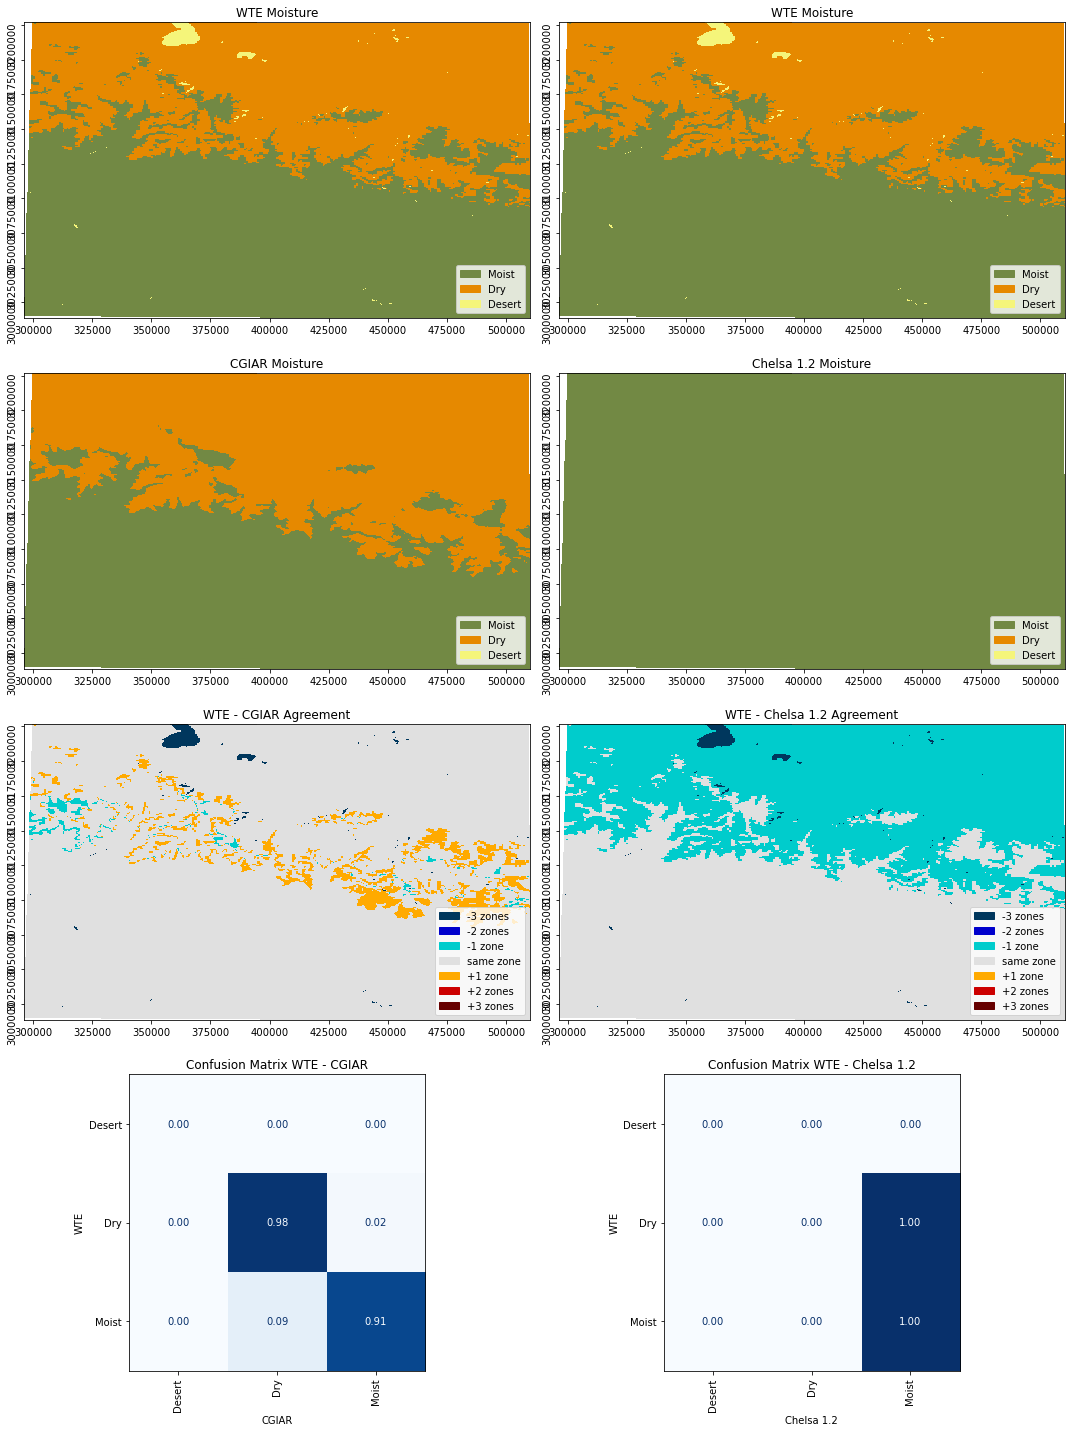

In [45]:
moisture_labels = ['Desert','Dry','Moist']

fig, ax = plt.subplots(4,2,figsize=(15,20))
fig = wte_moist_UTM_masked_cgiar[0].plot.imshow(ax=ax[0,0],cmap=cmap_moist,vmax=3, vmin=1,add_colorbar=False)
ax[0,0].set_title("WTE Moisture")
ax[0,0].legend(handles=legend,loc='lower right')
fig = wte_moist_UTM_masked_chelsa[0].plot.imshow(ax=ax[0,1],cmap=cmap_moist,vmax=3, vmin=1,add_colorbar=False)
ax[0,1].set_title("WTE Moisture")
ax[0,1].legend(handles=legend,loc='lower right')


fig = cgiar_to_wte_UTM_masked[0].plot.imshow(ax=ax[1,0],cmap=cmap_moist,vmax=3, vmin=1,add_colorbar=False)
ax[1,0].set_title("CGIAR Moisture")
ax[1,0].legend(handles=legend,loc='lower right')
fig = chelsa_to_wte_UTM_masked[0].plot.imshow(ax=ax[1,1],cmap=cmap_moist,vmax=3, vmin=1,add_colorbar=False)
ax[1,1].set_title("Chelsa 1.2 Moisture")
ax[1,1].legend(handles=legend,loc='lower right')


fig = wte_cgiar_diff[0].plot.imshow(ax=ax[2,0],cmap=diff_cmap,vmax=3, vmin=-3,add_colorbar=False)
ax[2,0].set_title("WTE - CGIAR Agreement")
ax[2,0].legend(handles=legend_diff,loc='lower right')
fig = wte_chelsa_diff[0].plot.imshow(ax=ax[2,1],cmap=diff_cmap,vmax=3, vmin=-3,add_colorbar=False)
ax[2,1].set_title("WTE - Chelsa 1.2 Agreement")
ax[2,1].legend(handles=legend_diff,loc='lower right')

        
cm_cgiar = confusion_matrix(wte_moist_UTM_masked_cgiar[0].fillna(-999).values.flatten(), cgiar_to_wte_UTM_masked[0].fillna(-999).values.flatten(), normalize=None, labels=[-999,1,2,3])
cm_cgiar = cm_cgiar[1:,1:]
plot_confusion_matrix(ax[3,0],cm_cgiar,[1,2,3],true="WTE",predicted="CGIAR")
ax[3,0].set_xticklabels(moisture_labels)
ax[3,0].set_yticklabels(moisture_labels)
ax[3,0].set_title("Confusion Matrix WTE - CGIAR")

cm_chelsa = confusion_matrix(wte_moist_UTM_masked_chelsa[0].fillna(-999).values.flatten(), chelsa_to_wte_UTM_masked[0].fillna(-999).values.flatten(), normalize=None, labels=[-999,1,2,3])
cm_chelsa = cm_chelsa[1:,1:]
plot_confusion_matrix(ax[3,1],cm_chelsa,[1,2,3],true="WTE",predicted="Chelsa 1.2")
ax[3,1].set_xticklabels(moisture_labels)
ax[3,1].set_yticklabels(moisture_labels)
ax[3,1].set_title("Confusion Matrix WTE - Chelsa 1.2")


# rotate y-tick labels
for i in ax[:3]:
    for k in i[:]:
        for label in k.get_yticklabels():
            label.set_rotation(90)
    
# remove all axis labels
for i in ax[:3]:
    for k in i[:]:
        k.set_xlabel("")
        k.set_ylabel("")  
        k.ticklabel_format(style='plain')

plt.tight_layout()
plt.plot()

[]

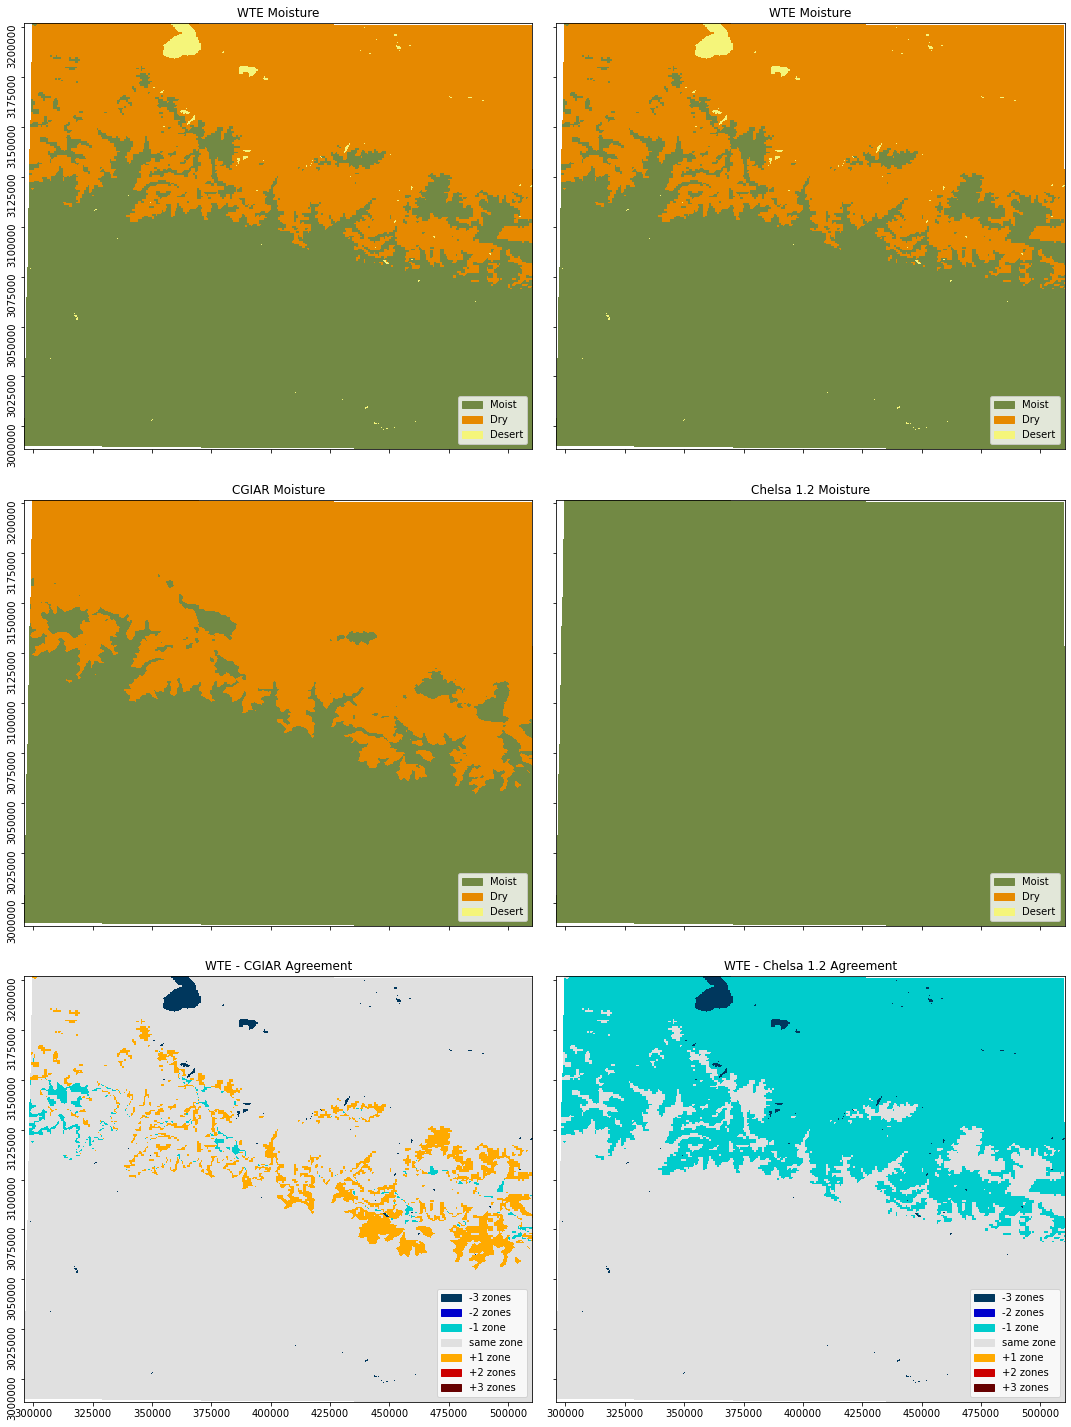

In [48]:
moisture_labels = ['Desert','Dry','Moist']

fig, ax = plt.subplots(3,2,figsize=(15,20))
fig = wte_moist_UTM_masked_cgiar[0].plot.imshow(ax=ax[0,0],cmap=cmap_moist,vmax=3, vmin=1,add_colorbar=False)
ax[0,0].set_title("WTE Moisture")
ax[0,0].legend(handles=legend,loc='lower right')
fig = wte_moist_UTM_masked_chelsa[0].plot.imshow(ax=ax[0,1],cmap=cmap_moist,vmax=3, vmin=1,add_colorbar=False)
ax[0,1].set_title("WTE Moisture")
ax[0,1].legend(handles=legend,loc='lower right')


fig = cgiar_to_wte_UTM_masked[0].plot.imshow(ax=ax[1,0],cmap=cmap_moist,vmax=3, vmin=1,add_colorbar=False)
ax[1,0].set_title("CGIAR Moisture")
ax[1,0].legend(handles=legend,loc='lower right')
fig = chelsa_to_wte_UTM_masked[0].plot.imshow(ax=ax[1,1],cmap=cmap_moist,vmax=3, vmin=1,add_colorbar=False)
ax[1,1].set_title("Chelsa 1.2 Moisture")
ax[1,1].legend(handles=legend,loc='lower right')


fig = wte_cgiar_diff[0].plot.imshow(ax=ax[2,0],cmap=diff_cmap,vmax=3, vmin=-3,add_colorbar=False)
ax[2,0].set_title("WTE - CGIAR Agreement")
ax[2,0].legend(handles=legend_diff,loc='lower right')
fig = wte_chelsa_diff[0].plot.imshow(ax=ax[2,1],cmap=diff_cmap,vmax=3, vmin=-3,add_colorbar=False)
ax[2,1].set_title("WTE - Chelsa 1.2 Agreement")
ax[2,1].legend(handles=legend_diff,loc='lower right')

# rotate y-tick labels
for i in ax[:3]:
    for k in i[:]:
        for label in k.get_yticklabels():
            label.set_rotation(90)
    
# remove all axis labels
for i in ax[:3]:
    for k in i[:]:
        k.set_xlabel("")
        k.set_ylabel("")  
        k.ticklabel_format(style='plain')
for i in ax[:2]:
    for k in i[:]:
        for i, tick in enumerate(k.xaxis.get_ticklabels()):
            tick.set_visible(False)
for i in ax[:]:
    for k in i[1:]:
        for i, tick in enumerate(k.yaxis.get_ticklabels()):
            tick.set_visible(False)
plt.tight_layout()
plt.plot()

[]

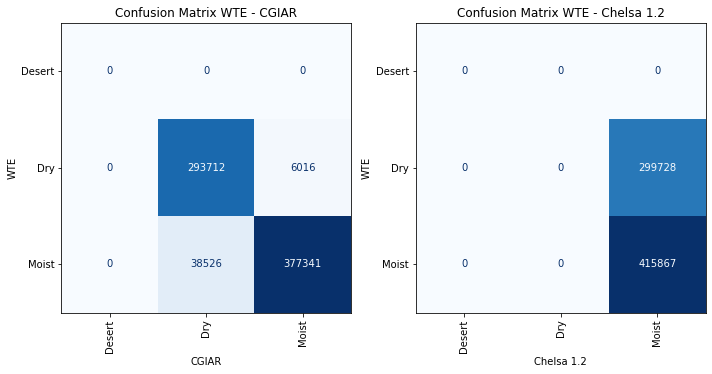

In [52]:
moisture_labels = ['Desert','Dry','Moist']

fig, ax = plt.subplots(1,2,figsize=(10,15))

cm_cgiar = confusion_matrix(wte_moist_UTM_masked_cgiar[0].fillna(-999).values.flatten(), cgiar_to_wte_UTM_masked[0].fillna(-999).values.flatten(), labels=[-999,1,2,3])
cm_cgiar = cm_cgiar[1:,1:]
plot_confusion_matrix(ax[0],cm_cgiar,[1,2,3],true="WTE",predicted="CGIAR",normalize=None)
ax[0].set_xticklabels(moisture_labels)
ax[0].set_yticklabels(moisture_labels)
ax[0].set_title("Confusion Matrix WTE - CGIAR")

cm_chelsa = confusion_matrix(wte_moist_UTM_masked_chelsa[0].fillna(-999).values.flatten(), chelsa_to_wte_UTM_masked[0].fillna(-999).values.flatten(), labels=[-999,1,2,3])
cm_chelsa = cm_chelsa[1:,1:]
plot_confusion_matrix(ax[1],cm_chelsa,[1,2,3],true="WTE",predicted="Chelsa 1.2",normalize=None)
ax[1].set_xticklabels(moisture_labels)
ax[1].set_yticklabels(moisture_labels)
ax[1].set_title("Confusion Matrix WTE - Chelsa 1.2")


plt.tight_layout()
plt.plot()